# Selecting systems at the Qzams, m1 edge in COMPAS

March 31 2025

Katie and Gina are not finding the same cutoff as I am in the q_ZAMS, M1 plane. 

This notebook is to highlight a few systems in that plane that do respect that boundary in my simualations and get their detailed evolution and ZAMS properties so that they can re-run 


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
import h5py as h5 
from astropy.table import Table
import os
import time 

# custom modules
import MinimumMassFunctions as mfunc
import importlib
importlib.reload(mfunc)


<module 'MinimumMassFunctions' from '/mnt/home/lvanson/BumpAt20/Code/MinimumMassFunctions.py'>

## Read simulation

In [19]:
#########################################
# Read COMPAS DCO data
#########################################
def read_data(loc = '', verbose=False):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            loc                  --> [string] Location of data
            rate_key             --> [string] group key name of COMPAS HDF5 data that contains your merger rate
            read_SFRD            --> [bool] If you want to also read in sfr data
            verbose              --> [bool] If you want to print statements while reading in 

        Returns:
            DCO                        --> [astropy table] contains all your double compact object
            DCO_mask                   --> [array of bool] reduces your DCO table to your systems of interest (determined in CI)
            rate_mask                  --> [array of bool] reduces intrinsic_rate_density to systems (flavour) of interest
            redshifts                  --> [array of floats] list of redshifts where you calculated the merger rate
            Average_SF_mass_needed     --> [float]    Msun SF needed to produce the binaries in this simulation
            intrinsic_rate_density     --> [2D array] merger rate in N/Gpc^3/yr
            intrinsic_rate_density_z0  --> [2D array] merger rate in N/Gpc^3/yr at finest/lowest redshift bin calculated

    """
    print('Reading ',loc)
    ################################################
    ## Open hdf5 file
    File        = h5.File(loc ,'r')
    if verbose: print(File.keys(), File[rate_key].keys())
    
    # Older simulations use this naming
    dcokey,  syskey, CEcount, dcomask = 'DoubleCompactObjects', 'SystemParameters', 'CE_Event_Count', 'DCOmask' 
    if dcokey in File.keys():
        if verbose: print('using file with key', dcokey)
    # Newer simulations use this
    else:
        if verbose: print('using file with key', dcokey)
        dcokey,  syskey, CEcount, dcomask = 'BSE_Double_Compact_Objects', 'BSE_System_Parameters', 'CE_Event_Counter', 'DCOmask'
 
    print(File[dcokey].keys())
    
    DCO = Table()
    for dco_param in ['SEED', 'Mass(1)', 'Mass(2)', 'Stellar_Type(1)', 'Stellar_Type(2)',
                      'MT_Donor_Hist(1)','MT_Donor_Hist(2)','dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)',
                      'Metallicity@ZAMS(1)', 'SemiMajorAxis@DCO', 'Eccentricity@DCO', 'Optimistic_CE', 'Immediate_RLOF>CE', CEcount]:
                      
        DCO[dco_param] = File[dcokey][dco_param][()]
        
    DCO['M_moreMassive']         = np.maximum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['M_lessMassive']         = np.minimum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['Mchirp']                = np.divide(np.power(np.multiply(DCO['M_moreMassive'], DCO['M_lessMassive']), 3./5.), np.power(np.add(DCO['M_moreMassive'], DCO['M_lessMassive']), 1./5.))

    SYS_DCO_seeds_bool           = np.in1d(File[syskey]['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
    # This needs to be done in two steps, otherwise the Snakemake workflow gets stuck for unknown reasons
    for sys_param in ['Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)']:
        SYSvalues = File[syskey][sys_param][()]
        DCO[sys_param]  =  SYSvalues[SYS_DCO_seeds_bool] 

    File.close()
    
    print('Done with reading DCO data for this file :)')
    return DCO


#############################
def read_and_mask(sim_dir='', rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
                  sim_name='', x_key='M_moreMassive', only_stable=True, only_CE=True):
    """
    This function reads and masks the data.
    """
    # Reading data ##
    DCO = read_data(loc = os.path.join(sim_dir, sim_name, 'output', 'COMPAS_Output_wWeights.h5')) # DCO data
    
    # Rate data
    with h5.File(os.path.join(sim_dir, sim_name, 'output', 'COMPAS_Output_wWeights.h5'),'r') as File:
        if rate_key in File.keys():
            final_rate_key = rate_key
        else:
            final_rate_key = next((key for key in File.keys() if key.startswith('Rates_')), None)
        redshifts                 = File[final_rate_key]['redshifts'][()]
        DCO_mask                  = File[final_rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        intrinsic_rate_density    = File[final_rate_key]['merger_rate'][()]

    #############################
    # Masking data ##
    mask_start_t = time.time()
    CEcount = 'CE_Event_Count' if 'CE_Event_Count' in DCO.columns else 'CE_Event_Counter' # Old simulations use CE_Event_Count, newer ones CE_Event_Counter
    
    #first bring it to the same shape as the rate table
    merging_BBH = DCO[DCO_mask]
    # Are you interested in only stable or only CE channels?
    if np.logical_and(only_stable, only_CE):
        channel_bool = np.full(len(merging_BBH), True)
        channel_string = 'All'
    elif only_stable:
        channel_bool = merging_BBH[CEcount] == 0
        channel_string = 'stable'
    elif only_CE:
        channel_bool = merging_BBH[CEcount] > 0
        channel_string = 'CE'
    else:
        raise ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
                
    # we exclude CHE systems
    not_CHE  = merging_BBH['Stellar_Type@ZAMS(1)'] != 16 
    BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)
    
    # Apply all masks
    merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
    Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]
    
    mask_end_t = time.time()
    print('done masking data: ', mask_end_t - mask_start_t, 'seconds')
        
    return merging_BBH, Red_intr_rate_dens, redshifts, channel_string

#############################
def get_table_and_min_MBH(beta = 0.5, zeta_list = [6.0], Fc1 = 0.34, sim_name = 'faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(1.0) ):# 'THERMAL' #     
     merging_BBH, Red_intr_rate_dens, redshifts, channel_string = read_and_mask(sim_name= sim_name,
                                             sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
                                             rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                                             only_stable=True, only_CE=False)

     merging_BBH.info()

     print(np.unique(merging_BBH['MT_Donor_Hist(1)'] )  )

     # Define color map for MT_Donor_Hist(1)
     color_map = {'1-2             ': 0, '2               ': 1,'2-7             ': 2, 'NA              ': 3}
     # print([val for val in M2_moremass_BBH['MT_Donor_Hist(2)']])

     # Create a new column 'color' in the table
     merging_BBH['MT1color'] = [color_map[val] if val in color_map else -1 for val in merging_BBH['MT_Donor_Hist(1)']]
     merging_BBH['MT2color'] = [color_map[val] if val in color_map else -1 for val in merging_BBH['MT_Donor_Hist(2)']]

     ##########################
     # Get analytcal solution 
     ##########################

     # Define the variables
     qzams       = np.arange(0.25,1.01, 0.01)
     use_zeta    = False

     q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta_list)
     qcrit2_list = q_crits[:,1]

     use_dMsn  = True
     A_sn      = -0.9  #-0.9
     B_sn      = 13.9  #13.9
     M_threshold = 14.8 #14.8

     # Simnames
     # simnames = ['faccFIXEDbeta0.5zetaHG%sRemMassFRYER2012SNDELAYED/'%(ZETA) for ZETA in zeta_list]

     ##########################
     # Define values and add columns
     i_redshift = np.where(redshifts == 0.2)[0][0]
     Weights = Red_intr_rate_dens[:, i_redshift]
     merging_BBH['qZAMS'] = merging_BBH['Mass@ZAMS(2)']/merging_BBH['Mass@ZAMS(1)']
     # Define color map for MT_Donor_Hist
     color_map = {'1-2             ': 0, '2               ': 1,'2-7             ': 2, 'NA              ': 3}
     # Create a new column 'color' in the table
     merging_BBH['MT1color'] = [color_map[val] if val in color_map else -1 for val in merging_BBH['MT_Donor_Hist(1)']]
     merging_BBH['MT2color'] = [color_map[val] if val in color_map else -1 for val in merging_BBH['MT_Donor_Hist(2)']]

     ##########################
     # Get minimum Mbh1,2 and ZAMS
     ##########################
     MBH1_list, MBH2_list, MZAMS_list = [],[],[]
     for qi, qcrit2 in enumerate(qcrit2_list):
          # Mbh1
          Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta_list[qi], qcrit1 = qzams, qcrit2 = qcrit2, 
                                                       Fc1 = Fc1, M_threshold = M_threshold,Beta = beta, verbose = False,
                                                       use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
          MBH1_list.append(Min_MBH1)
          # Mbh2
          minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
          MBH2_list.append(minM_BH2)
          # Mzams1
          Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = beta, fc1 = Fc1, asn = A_sn, bsn= B_sn)
          MZAMS_list.append(Minzams1)

     print('qzams', qzams, 'Min_MBH1',Min_MBH1 , 'minM_BH2', minM_BH2)
     
     return merging_BBH, Red_intr_rate_dens, redshifts, Min_MBH1, minM_BH2, MZAMS_list, qzams, qcrit2_list, zeta_list

##################################

BETA = 1.0
sim_name = 'faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA)  # 'faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA) # 'THERMAL' 
     
merging_BBH, Red_intr_rate_dens, redshifts, Min_MBH1, minM_BH2, MZAMS_list, qzams, qcrit2_list, zeta_list =\
    get_table_and_min_MBH(beta = BETA, zeta_list = [6.0], Fc1 =1.0*0.34, sim_name = sim_name) #

M1_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'] ]
M2_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'] ]

i_redshift = np.where(redshifts == 0.2)[0][0]
M1_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'], i_redshift]
M2_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'], i_redshift]





Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/faccFIXEDbeta1.0zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
<KeysViewHDF5 ['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity@DCO', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)', 'mixture_weight']>
Done with reading DCO data for this file :)
done masking data:  0.9635319709777832 seconds
<Table length=1029355>
        name          dtype 
-------------------- -------
                SEED  uint64
             Mass(1) float64
             Mass(2) float64
     Stellar_Type(1)   int32
     Stellar_Type(2)   int32
    MT_Donor_Hist(1) bytes17
    MT_Donor_Hist(2) bytes17
             dmMT(1) float64
             dmMT(2) float64


## plot the Q_zams, m1 plane

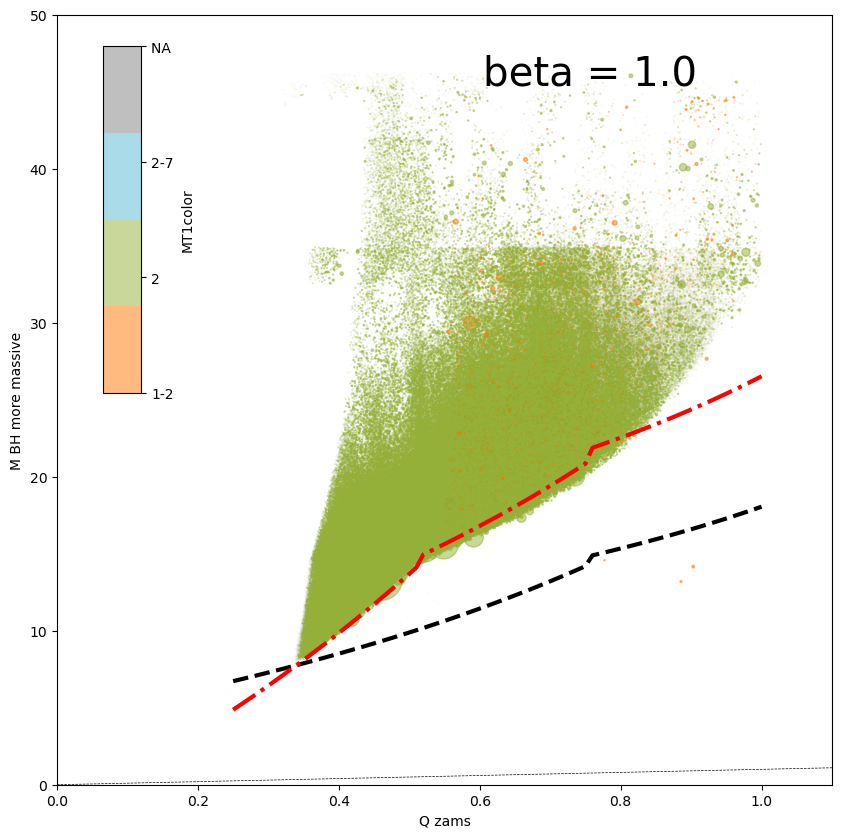

In [21]:
to_plot_table = M2_moremass_BBH #merging_BBH #
to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']

to_plot_weight = M2_moremass_Weights # Weights # 

colors = ['#ff7800', '#95b038','#54b9d3','grey'] # Define the colors for 0, 1, 2, 3
discrete_cmap = ListedColormap(colors) # Create the colormap
# Define color map for MT_Donor_Hist(1)
color_map = {'1-2             ': 0, '2               ': 1,'2-7             ': 2, 'NA              ': 3}

##########################
# Scatter plot
##########################
fig, ax = plt.subplots(figsize = (10, 10))

plt.plot(np.linspace(0,50,100), np.linspace(0,50,100), '--', color='k', lw = 0.5)

kleur = 'MT1color' #'log Z' # # np.log10(M2_moremass_BBH['Metallicity@ZAMS(1)'])
im = plt.scatter(to_plot_table['qZAMS'], to_plot_table['M_moreMassive'], 
            s = 4000* to_plot_weight, c = to_plot_table[kleur], marker = 'o', 
            alpha = 0.5, vmin = 0, vmax = 3,  cmap = discrete_cmap,) #cmap = 'viridis')

# Create an inset axes for the colorbar
cax = inset_axes(ax,``
                 width="5%",  # width = 5% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left', bbox_to_anchor=(0.05, 0.5, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(im, cax=cax, orientation="vertical",label = kleur )
# Set the colorbar tick locations and labels for MT map
cbar.set_ticks(list(range(len(color_map) )))
cmap_ticks = [key.replace('             ', '') for key in color_map.keys()]
cbar.set_ticklabels(cmap_ticks)

### 
ax.plot(qzams, Min_MBH1, color = 'k', lw = 3, ls = '--', label = 'min Mbha')
ax.plot(qzams, minM_BH2, color = 'red', lw = 3, ls = '-.', label = 'min Mbhb')

# print('qzams', qzams, 'Min_MBH1',Min_MBH1 , 'minM_BH2', minM_BH2)


ax.text(0.55, 0.95, 'beta = %s' % (BETA), ha='left', va='top', transform=ax.transAxes, size=29)

ax.set_xlabel('Q zams')
ax.set_ylabel('M BH more massive')
ax.set_ylim(0,50)
ax.set_xlim(0,1.1)
plt.savefig('qzams_vs_MBH1_beta%s.png'%(BETA))
plt.show()

In [23]:
print(to_plot_table['M_moreMassive','qZAMS'])

  M_moreMassive           qZAMS       
------------------ -------------------
 17.36613961147496 0.46385789493946183
 20.72438023879029   0.623953359706332
25.028671373248834  0.6428619859147596
21.316029215116664  0.6124186205718529
27.627208953258748  0.9094524527441157
23.473137079809508  0.7047206048391247
 36.21523401889803  0.5887942257282643
 27.73082611767369  0.7321504558397639
 36.34868429321363  0.5438542771411524
30.667424679406277   0.896771706883915
               ...                 ...
18.735690890645518  0.4914988923192185
 24.65481201637473  0.7284091539432861
37.960366420307246 0.47937260033030205
 28.18450058107403  0.8493095538605117
 18.46888416617696  0.5943704145685065
30.735716320374866  0.7191879689708074
23.436626535432808    0.58131973445868
18.111341605841226  0.4351559166375406
18.240949475584923  0.5128250972932716
29.094521402507866  0.6836876279903488
Length = 863886 rows


In [27]:
# for the median q_ZAMS value in the following qzams bin:
q_ZAMS_bin_edges = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Take the minimum mass of the more massive BH
min_M_more_massive = np.zeros(len(q_ZAMS_bin_edges)-1)
for i in range(len(q_ZAMS_bin_edges)-1):
    q_ZAMS_bin = to_plot_table[(to_plot_table['qZAMS'] >= q_ZAMS_bin_edges[i]) & (to_plot_table['qZAMS'] < q_ZAMS_bin_edges[i+1])]
    # get the index of the system with min(M_moreMassive)
    i_min = np.argmin(q_ZAMS_bin['M_moreMassive']) 
    print(q_ZAMS_bin['M_moreMassive','qZAMS'][i_min])
    # Print the table sorted by M_moreMassive
    print(q_ZAMS_bin['M_moreMassive','qZAMS'].sort('M_moreMassive'))


to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']

  M_moreMassive         qZAMS       
----------------- ------------------
9.518546975137332 0.4192579172991601
None
  M_moreMassive         qZAMS       
----------------- ------------------
10.00885092159653 0.5041637243247714
None
  M_moreMassive          qZAMS       
------------------ ------------------
11.660970784466995 0.6411124147208926
None
  M_moreMassive          qZAMS       
------------------ ------------------
14.579596226528915 0.7769423405942366
None
  M_moreMassive          qZAMS       
------------------ ------------------
13.188282777665265 0.8856486266061451
None
